Introduction!
===

In this notebook we will predict the gender of an Egyptian fruit bat given only a vocalization sample. We'll use a CQ transformed version of the tiny subset of annotated vocalization data to speed up the training time (a set of CQ transformed vocalizations rather than just a set of annotated vocalizations). We will be testing the effect of the number of masked input channels on the performance of a given model, and so for each model architecture we will run many samples to get a better idea about average performance for a given number of input channels. More information on this sequential masking of the input data can be found [here](https://github.com/oliver-adams-b/library/blob/main/egyptian_fruit_bat/efb_context_labeler_pos_enc_comparison.ipynb). 

In [3]:
from fastai.vision.all import *
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [4]:
dest_path = "/home/jupyter/data/"
path = Path("{}egyptian_fruit_bat_annotated_tiny_cqt".format(dest_path))
files = [str(x) for x in get_image_files(path)]
annot_path = "{}/egyptian_fruit_bat_annotated_tiny/better_annotations.csv".format(dest_path)

We are given bat ID's not bat gender from the annotations file, but we can use the metadata for the datasets to figure out which bat ID's correspond to male vs. female bats. As noted in the metadata, all ID's which are negative or zero correspond to uncertain/unknown labels, and so we throw out all samples where this is the case. 

In [5]:
def format_annotations(annot_path):
    annotations = pd.read_csv(annot_path)
    context_dict = {0:"unknown", 1:"separation", 2:"biting", 
                    3:"feeding", 4:"fighting", 5:"grooming", 
                    6:"isolation", 7:"kissing", 8:"landing", 
                    9:"mating protest", 10:"threat-like", 
                    11:"general", 12:"sleeping"}

    annotations["Context desc."] = [context_dict[x] for x in annotations["Context"]]
    annotations["File name"] = [x.replace(".WAV", ".png") for x in annotations["File name"] ]
    annotations["File path"] = ["{}/{}/{}".format(str(path),
                                                  str(annotations['File folder'][i]), 
                                                  str(annotations['File name'][i])) for i in annotations.index]
    annotations = annotations[annotations["File path"].isin(files)]
    annotations = annotations.drop_duplicates(subset = ['File path'])
    return annotations

#a direct copy of a table found in the metadata:
addressee_sex_dict = {101:"M", 102:"F", 103:"M", 104:"F", 
                      105:"F", 106:"F", 107:"F", 108:None, 
                      109:"F", 110:"F", 111:"F", 112:"F", 
                      113:None, 114:"F", 115:"F", 116:"M", 118:"F", 
                      119:"F", 120:None, 201:"F", 202:None,
                      203:"F", 204:"F", 205:"F", 207:"M", 
                      208:"M", 209:"F", 210:None, 211:"F", 
                      212:"F", 213:"F", 214:None, 215:"F", 
                      216:"F", 217:"F", 218:"M", 220:None, 221:"M", 
                      222:None, 223:"F", 224:"F", 225:"F", 
                      226:"F", 228:"F", 230:None, 231:"M", 
                      232:"F", 233:"M"}

annotations = format_annotations(annot_path)
annotations = annotations[annotations["Addressee"]>0]
annotations["Addressee sex"] = [addressee_sex_dict[x] for x in annotations["Addressee"]]
annotations = annotations.dropna()
annotations.head()


,Unnamed: 0,FileID,Emitter,Addressee,Context,Emitter pre-vocalization action,Addressee pre-vocalization action,Emitter post-vocalization action,Addressee post-vocalization action,Start sample,End sample,File name,File folder,Context desc.,File path,Addressee sex
6483,6483,31587,103,104,0,0,0,0,0,1,328528,120724074714562429.png,files104,unknown,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files104/120724074714562429.png,F
7044,7044,32934,105,106,0,0,0,0,0,1,377680,120728234433909678.png,files104,unknown,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files104/120728234433909678.png,F
7052,7052,32969,105,106,0,0,0,0,0,1,320336,120729003055701681.png,files104,unknown,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files104/120729003055701681.png,F
7434,7434,34086,105,106,0,0,0,0,0,1,344912,120731190649433843.png,files104,unknown,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files104/120731190649433843.png,F
8260,8260,36665,105,106,0,0,0,0,0,1,336720,120803190018516012.png,files104,unknown,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files104/120803190018516012.png,F


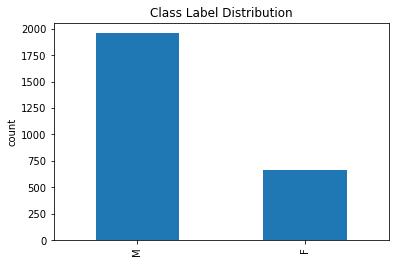

In [6]:
annotations["Addressee sex"].value_counts().plot(kind = 'bar', title = "Class Label Distribution", ylabel = "count")
plt.show()

Next, we'll create some utility functions to help us create our models and dataloaders. 

In [7]:
def get_x(p):
    #returns a gs numpy array
    return  np.array(Image.open(p))[:, :, 0]

def pos_enc2d_np(gs_im, out_c = 5, eta = 0.05):
    def constrain(x, a, b):
        if x > b: return b
        if x < a: return a
        else: return x

    def make_mask(shape, start, end):
        #returns a vertical mask:
        block_0 = np.zeros((shape[1], start))
        block_1 = np.ones((shape[1], end - start))
        block_2 = np.zeros((shape[1], constrain(shape[0] - end, 0, shape[0])))
        mask = np.block([block_0, block_1, block_2])
        
        if mask.shape != shape:
            return mask[:shape[1], :shape[1]]
        else: return mask

    window_widths = np.random.uniform(float(1/(out_c-1.05)) - eta, 
                                      float(1/(out_c-1.05)) + eta, out_c)
    window_widths = np.round(window_widths*gs_im.shape[0]).astype(int)   
    
    window_starts = np.random.uniform(float(1/out_c) - eta, 
                                      float(1/out_c) + eta, out_c)
    
    window_starts = np.array([sum(window_starts[0:i]) for i in range(out_c)])
    window_starts = np.round(window_starts*gs_im.shape[0]).astype(int)   
    new_ims = []
    
    for i in range(out_c):
        if i < out_c:
            temp_mask = make_mask(gs_im.shape, 
                                  start = window_starts[i], 
                                  end = window_starts[i] + window_widths[i])
        if i == out_c:
            #making sure the last mask gets the last of the image:
            temp_mask = make_mask(gs_im.shape, 
                                  start = int(gs_im.shape[0]*out_c), 
                                  end = gs_im.shape[0])

        new_ims.append(np.multiply(temp_mask, gs_im))
    return np.dstack(new_ims) 

def pos_enc2d_layer(tensor, out_c = 6, eta = 0.05):
    #adapting the pos_enc2d to act as a layer in the model:
    bs, channels, h, w = tensor.shape
    assert channels == 1, "Input should have one channel!"
    np_tensor = np.array(tensor.cpu()) #a little hacky! probably could be better!
    stack = [pos_enc2d_np(np_tensor[i,:, :, :].reshape(h, w), out_c, eta) for i in range(bs)]
    stack  = np.array(stack).reshape(bs, out_c, h, w)
    return torch.from_numpy(stack).type(torch.cuda.FloatTensor)

def get_y(p, annotations = annotations, class_label = "Addressee sex"):
    return annotations.loc[annotations['File path'] == p][class_label].values[0]

def get_items(p, annotations = annotations):
    temp_files = [str(x) for x in get_image_files(path)]
    return annotations.loc[annotations['File path'].isin(temp_files)]['File path'].values

items = get_items(path)
print(get_y(items[0]))

F


Now to create our model architecture. We'll use a pretrained resnet18 with a custom model head parameterized by the provided number of input channels. With `n_c_layers = 1` we have no encoder head. 

In [8]:
class res_model(Module):    
    def __init__(self, n_c_layers = 5):
        super().__init__()
        
        self.with_pos_enc = n_c_layers != 1
        self.in_c = (1, n_enc_layers)[self.with_pos_enc]
        self.encoder_head = nn.Sequential(
                                    nn.Conv2d(in_channels = self.in_c,     
                                             out_channels = 3, 
                                             kernel_size = (5, 5), 
                                             stride = (1, 1), 
                                             padding = (1, 1), 
                                             bias = True),
                                    nn.ReLU(inplace = True))
        
        self.res_block = resnet18()
        
    def forward(self, x):
        if self.with_pos_enc:
            x = pos_enc2d_layer(x, out_c = self.in_c)
        x = self.encoder_head(x)
        return self.res_block(x)

We'll also use a simple no overfitting callback during training so there is no guesswork with deciding how many epochs the various models should be trained for. This callback raises a `CancelFitException()` when the training loss is within `min_delta` of the validation loss for more than a provided number of epochs (`patience`). 

In [9]:
class NoOverfittingCB(Callback):
    def __init__(self, 
                 patience = 3, 
                 min_delta = 0.05, 
                 reset_on_fit = True):
        self.patience, self.min_delta, self.reset_on_fit, self.wait = patience, min_delta, reset_on_fit, 0
    
    def before_fit(self):
        self.run = not hasattr(self, "lr_finder") and not hasattr(self, "gather_preds")
        if self.reset_on_fit is None: self.wait = 0;
        self.vidx = list(self.recorder.metric_names[1:]).index("valid_loss")
        self.lidx = list(self.recorder.metric_names[1:]).index("train_loss")
    
    def after_epoch(self):
        vval = self.recorder.values[-1][self.vidx]
        tval = self.recorder.values[-1][self.lidx]
        
        diff = tval - vval + self.min_delta
        
        if diff < 0:
            self.wait += 1
        else:
            self.wait = 0
        if self.wait >= self.patience:
                print("Fit cancelled due to overfitting...")
                raise CancelFitException()
                
    def after_fit(self): 
        self.run = True
        

Now packaging most of the above functions into functions that grab a dataloader and model. The dataloader uses random splitting, and each model uses the above no overfitting callback as well as an early stopping callback. 

In [16]:
def get_random_dls():
    return DataBlock(blocks = (ImageBlock, CategoryBlock), 
               get_items = get_items, 
               get_x = get_x, 
               get_y = get_y, 
               splitter = RandomSplitter(seed = 42)).dataloaders(path, 
                                                                 bs = 32)
def get_learner_with_c(c, dls):
    learn = Learner(dls, res_model(n_c_layers = c), 
                    metrics = accuracy,
                    cbs=[EarlyStoppingCallback(monitor='valid_loss', 
                                               min_delta=0.05, 
                                               patience=4), 
                        NoOverfittingCB()])
    learn.unfreeze()
    return learn

We'll test models with number of input channels ranging from 1 to 5, sampling 20 models for each value. We'll also save the best model over the whole test so we can probe it later!

In [17]:
c_range = list(range(1, 6))
valid_acc_scores = []
valid_bce_scores = []
n_samps_per_c = 20
max_acc = 0
best_learner = None

We use the %%capture magic command to supress the immense amount of printing that the next few lines of code will output. No convenient tqdm progress bar here, so if you run this get ready to wait a while!

In [18]:
%%capture
for c in c_range:
    for i in range(n_samps_per_c):
        temp_dls = get_random_dls()
        temp_learner = get_learner_with_c(c, temp_dls)
        temp_learner.fit_one_cycle(8)
        temp_valid = list(temp_learner.validate())
        valid_acc_scores.append([c, temp_valid[1]])
        valid_bce_scores.append([c, temp_valid[0]])
        
        if temp_valid[1]>max_acc:
            max_acc = temp_valid[1]
            best_learner = temp_learner
            
        del temp_dls; del temp_learner; del temp_valid;

In [23]:
valid_acc_scores = np.array(valid_acc_scores)
valid_bce_scores = np.array(valid_bce_scores)

To visualize the results we'll use a ridgeline-like plot to get a more clear idea about the distribution of model architecture performance over many trials. 

In [24]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

def ridgeline(data,
              x_vals,
              overlap=0, 
              labels=None, 
              n_points=150):
    
    xx = np.linspace(np.min(np.concatenate(data)),
                     np.max(np.concatenate(data)), n_points)
    curves = []
    ys = []
    for i, d in enumerate(data):
        pdf = gaussian_kde(d)
        y = i*(1.0-overlap)
        ys.append(y)
        curve = pdf(xx)
        plt.plot((curve)/(np.max(curve)*3) + x_vals[i], xx, 
                 c='k', zorder=len(data)-i+1)
    plt.xticks(x_vals)
    
    if labels:
        plt.yticks(ys, labels)

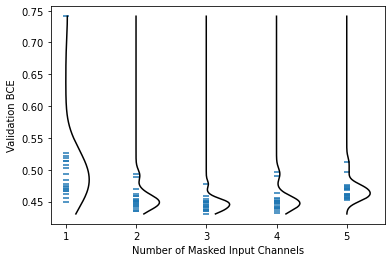

In [25]:
c_range = list(range(1, 6))
ridgeline_data = []
for c in c_range:
    c_mask = valid_bce_scores[:, 0] == c
    if sum(c_mask) != 0:
        ridgeline_data.append(valid_bce_scores[c_mask][:, 1])
ridgeline_data = np.array(ridgeline_data)

ridgeline(ridgeline_data, x_vals = c_range)
plt.scatter(valid_bce_scores[:, 0], 
            valid_bce_scores[:, 1], marker = "_")
plt.xlabel("Number of Masked Input Channels")
plt.ylabel("Validation BCE")
plt.xticks(c_range)
plt.show()

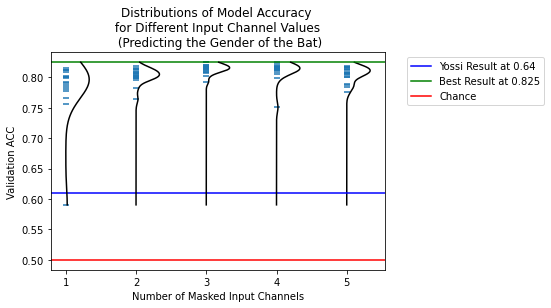

In [46]:
ridgeline_data = []
for c in c_range:
    c_mask = valid_acc_scores[:, 0] == c
    if sum(c_mask) != 0:
        ridgeline_data.append(valid_acc_scores[c_mask][:, 1])
ridgeline_data = np.array(ridgeline_data)

ridgeline(ridgeline_data, x_vals = c_range)
plt.scatter(valid_acc_scores[:, 0], 
            valid_acc_scores[:, 1], marker = "_")
plt.xlabel("Number of Masked Input Channels")
plt.axhline(0.61, 
            label = "Yossi Result at 0.64", 
            c = "b")
plt.axhline(np.max(ridgeline_data), 
            label = "Best Result at {}".format(np.max(ridgeline_data).round(decimals = 3)), 
            c = "g")
plt.axhline(0.5, 
            label = "Chance", 
            c = "r")
plt.ylabel("Validation ACC")
plt.xticks(c_range)
plt.legend(loc = 'best', 
          bbox_to_anchor=(1.05, 1))
plt.title("Distributions of Model Accuracy \n for Different Input Channel Values \n (Predicting the Gender of the Bat)")
plt.show()

In [44]:
print("Best learner had {} input channels!".format(best_learner.model.in_c))

Best learner had 3 input channels!
